# Jiamu Machine Learning Spectroscopy Project

The goal of this project is to use fully-connected networks to measure the properties of Quasar emission lines. Two main properties are: 

1. Line width (FWHM); 

2. Central wavelength (from this we can calculate the redshift of individulal line);

3. Line intensity (the line ratios tell us about the physical (as well as chemical) properties in Quasar broad line region. 

We first import the quasar spectral data from SDSS survey:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina' 
import numpy as np
import time
import torch.nn
from torch import nn
import torch.nn.functional
import torch.optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
# Your code here
#raise NotImplementedError()
from astropy.io import fits 
import os
foldername = '/Users/huangjiamu/Desktop/TDSS/'
filenameList = []
for filename in os.listdir(foldername):
    if (filename.endswith(".fits") or filename.endswith('.FITS')):
        filenameList.append(foldername + filename)

#### All files used in Problem 3 can be found at my repo for this project: https://github.com/jiamuH/Phys152_Machine_Learning

Now make a dictionary to store the training data:

In [3]:
tdss_dict = {'TargetName':[], 'Wave':[], 'Flux':[], 'Error':[], 'Redshift':[]}
for file in filenameList:
    tdss = fits.open(file)
    flux = tdss[1].data['flux']
    wave = 10**(tdss[1].data['loglam'])
    ivar = tdss[1].data['ivar']
    z = tdss[2].data['z'][0]
    
    name = (file.split('TDSS/')[1])

    tdss_dict['TargetName'].append(name)
    tdss_dict['Wave'].append(wave)
    tdss_dict['Flux'].append(flux)
    tdss_dict['Error'].append(1/np.sqrt(ivar))
    tdss_dict['Redshift'].append(z)

/var/folders/br/6sw3kv492t7c0z79vwnhb9gr0000gn/T/ipykernel_4871/2912063526.py:14: RuntimeWarning: divide by zero encountered in true_divide
  tdss_dict['Error'].append(1/np.sqrt(ivar))


In [4]:
print('Total number of training data is %.f' %len(tdss_dict['TargetName']))

Total number of training data is 43


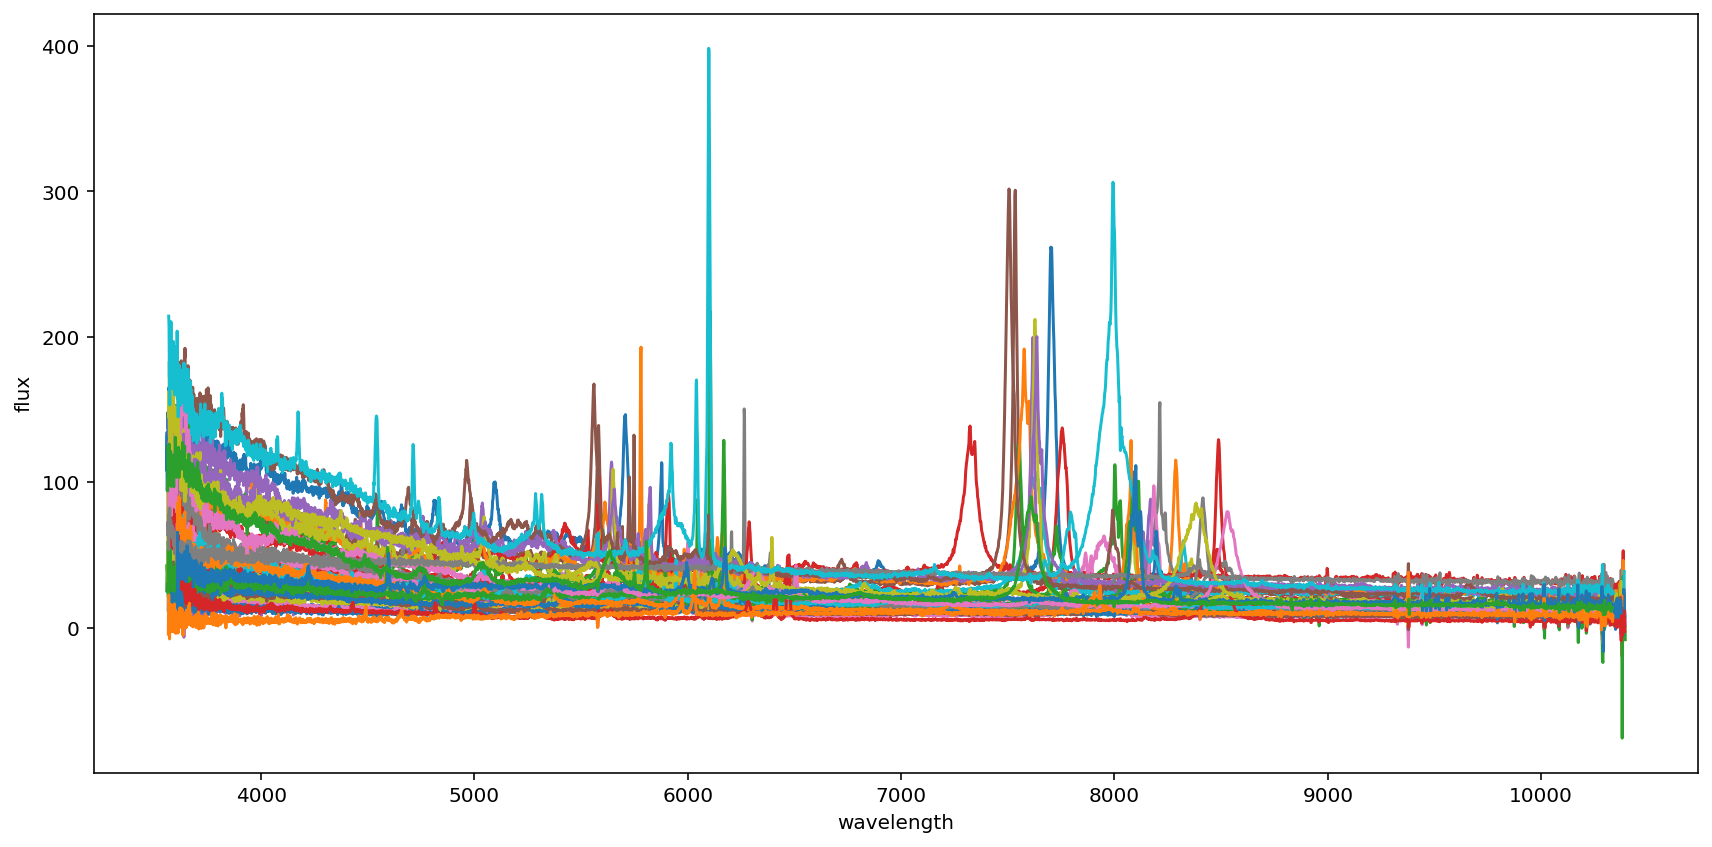

In [5]:
plt.figure(figsize=[12,6])
for i in range(len(filenameList)):
    plt.plot(tdss_dict['Wave'][i],tdss_dict['Flux'][i],label='')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.tight_layout()
plt.show();

Now shift all spectrum to the rest-frame wavelength based on thier redshifts:
$$ \lambda_0 = \lambda / (1+\rm redshift)$$

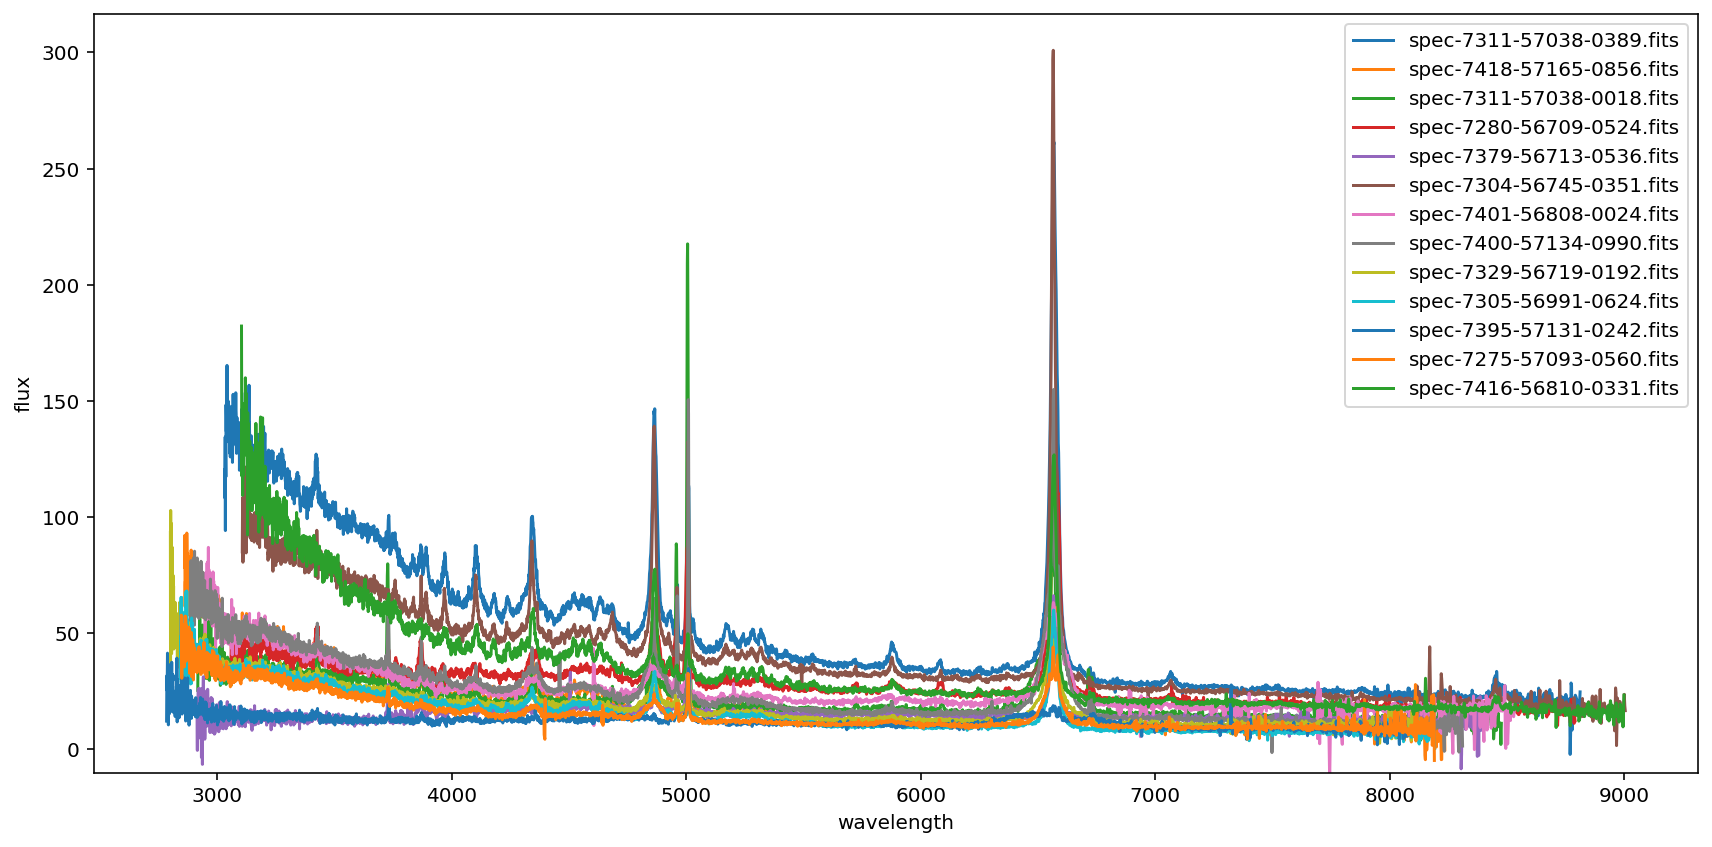

In [6]:
plt.figure(figsize=[12,6])
for i in range(len(filenameList)-30):
    plt.plot(tdss_dict['Wave'][i]/(1+np.array(tdss_dict['Redshift'][i])), tdss_dict['Flux'][i],label=tdss_dict['TargetName'][i])
plt.xlabel('wavelength')
plt.ylabel('flux')
#plt.title(f'{target_name[star]}')
plt.tight_layout()
plt.ylim(-10,)
plt.legend()
plt.show();

Zoom in to the $H{\beta}$ region to see it better.

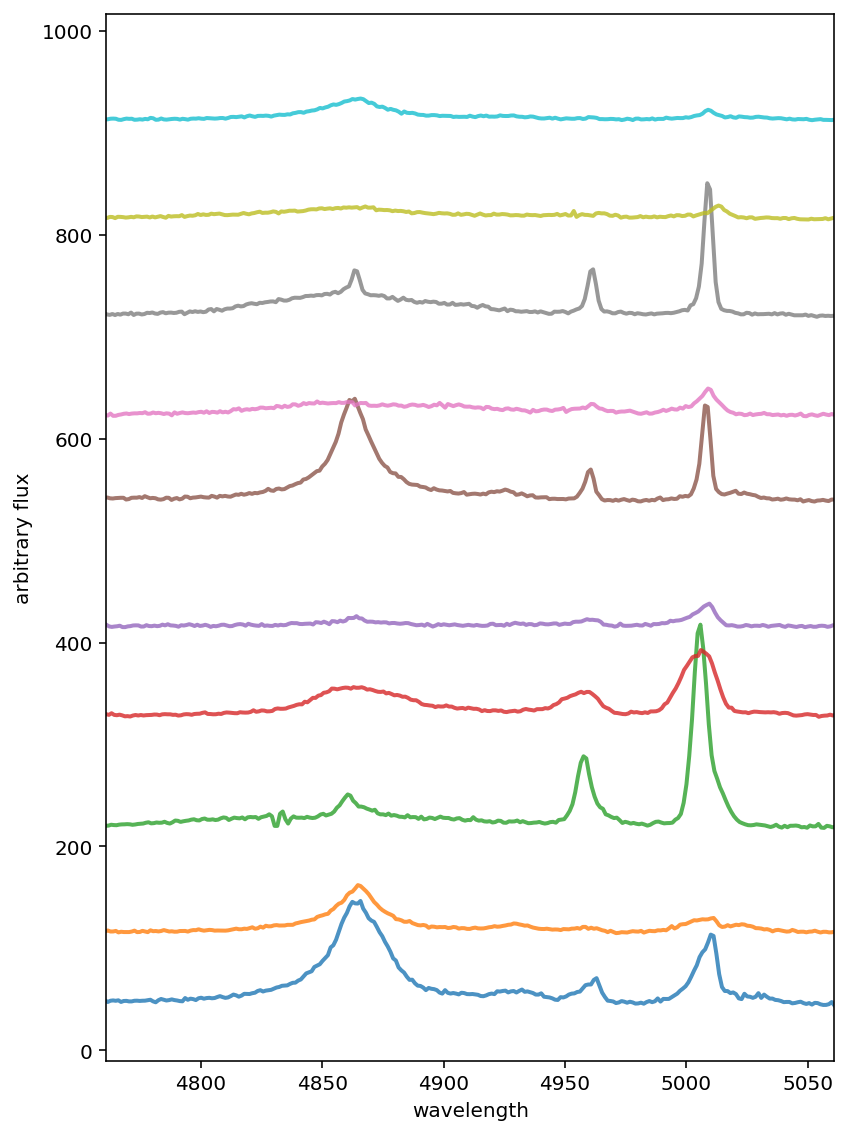

In [7]:
plt.figure(figsize=[6,8])
for i in range(10):
    plt.plot(tdss_dict['Wave'][i]/(1+np.array(tdss_dict['Redshift'][i])), \
             tdss_dict['Flux'][i] + 100*i,label=tdss_dict['TargetName'][i], alpha = 0.8,lw=2)
plt.xlabel('wavelength')
plt.ylabel('arbitrary flux')
#plt.title(f'{target_name[star]}')
plt.tight_layout()
plt.xlim(4861-100, 4861+200)
plt.ylim(-10,)
#plt.legend()
plt.show();

In [8]:
all_flux = np.concatenate(tdss_dict['Flux'], axis=None)

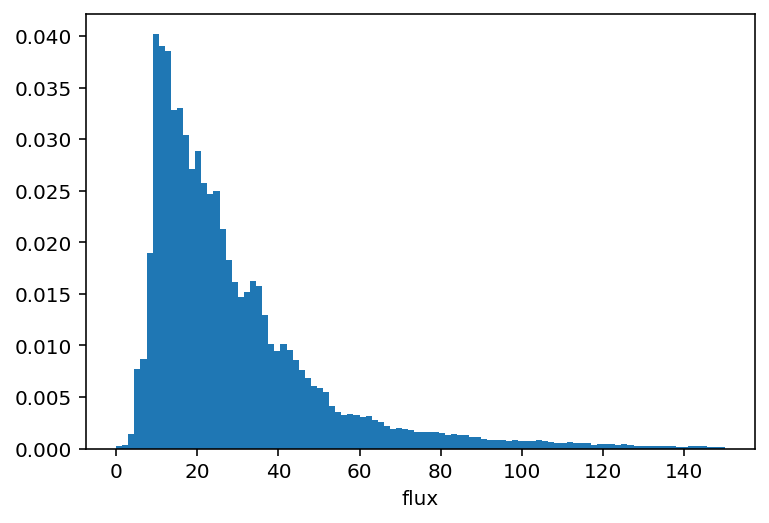

In [9]:
plt.figure(figsize=[6,4])
plt.hist(all_flux,bins=100, range=[0,150], density=True)
plt.xlabel('flux');

# plt.figure(figsize=[6,4])
# plt.hist(wave_comp,bins=100)

# plt.figure(figsize=[6,4])
# plt.hist(err_comp,bins=100, range=[0.,0.05],cumulative=True,histtype='step',density=True,lw=3);
# plt.xlim(0,0.04);

The distribution of fluxes for all the spectra looks just like a Poisson distribution, which is what I have expected. Now look at the composite spectrum as one of the test data:

In [10]:
spec = fits.open('/Users/huangjiamu/Desktop/composite_qso_spec/harris15_composite.fits')
spec[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   12 /Number of bytes per row                         
NAXIS2  =                 8000 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    3 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [11]:
wave_comp = spec[1].data['WAVE']
flux_comp = spec[1].data['FLUX']
err_comp = spec[1].data['ERR']

Text(0.5, 1.0, 'Distribution of Wavelength for Composite Spectrum')

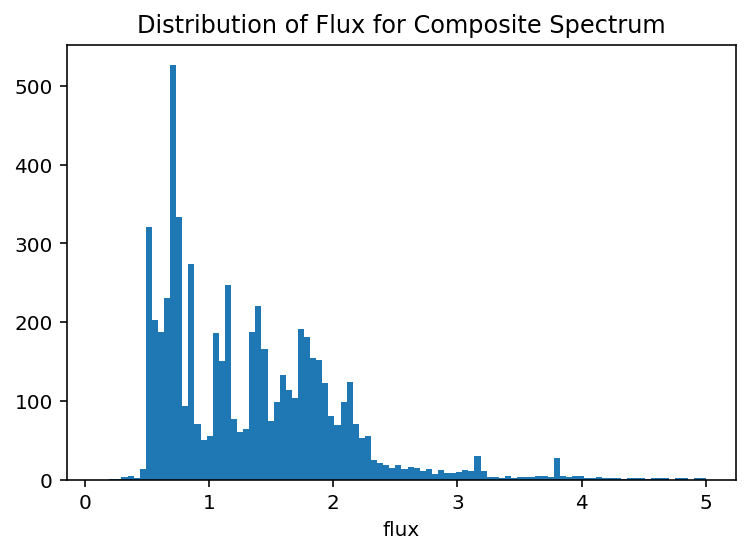

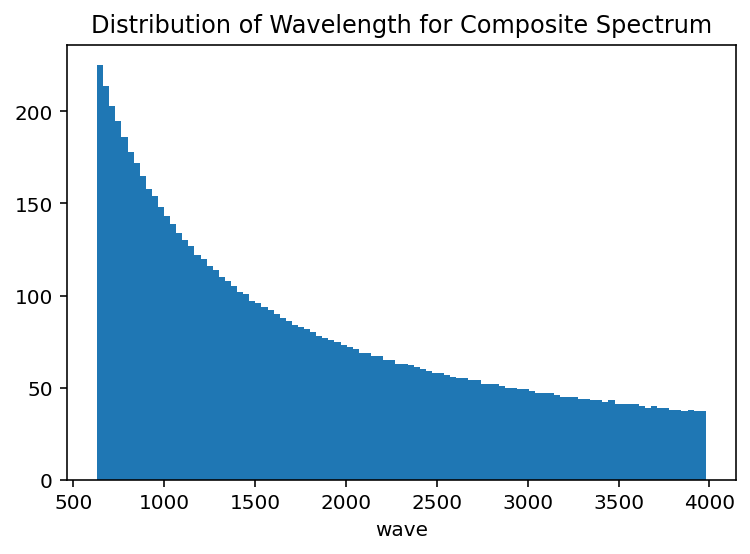

In [12]:
plt.figure(figsize=[6,4])
plt.hist(flux_comp,bins=100, range=[0.1,5])
plt.xlabel('flux')
plt.title('Distribution of Flux for Composite Spectrum')
plt.figure(figsize=[6,4])
plt.hist(wave_comp,bins=100)
plt.xlabel('wave')
plt.title('Distribution of Wavelength for Composite Spectrum')
# plt.figure(figsize=[6,4])
# plt.hist(err_comp,bins=100, range=[0.,0.05],cumulative=True,histtype='step',density=True,lw=3);
# plt.xlim(0,0.04)

The distribution of wavelength values shows that the spacing of wavelength is smaller on the blue side of the spectrum. This is because the cosmological redshift stretches longer wavelength more than the shorter wavelength. This is not directly related to my project, but it would be great if my neural networks can know the wavelength spacing when after they learned to fit the spectrum.

Now, plot the spectrum to get an general view:

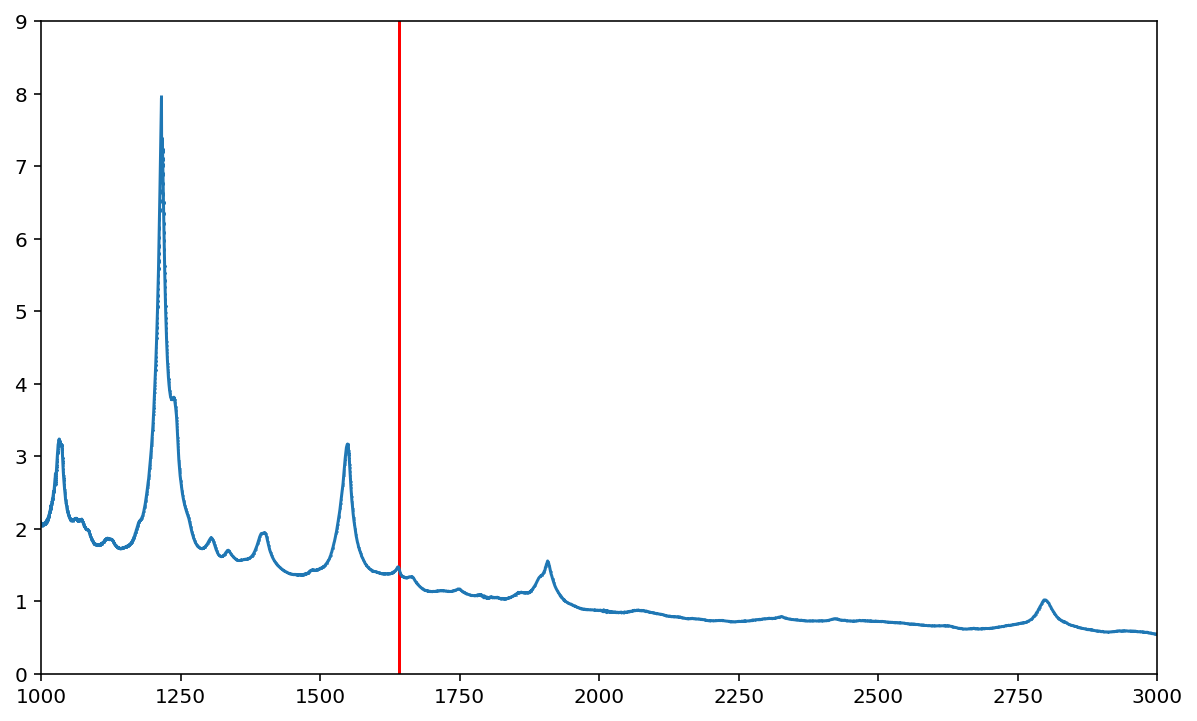

In [13]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina' 
plt.figure(figsize=[10,6])
plt.errorbar(wave_comp,flux_comp,yerr=err_comp)
plt.axvline(x=1640.43,color='r')
plt.xlim(1000,3000)
plt.ylim(0,9);

In [14]:
stacked = np.vstack((wave_comp,flux_comp))

In [15]:
'''
Define a few functions that can be helpful to fit the spectrum. The noisify function is taken from the 'lectures2'
note book. And Gaussian/Underline is just simple function to fit the line profile and spectral continuum. I am not
sure which one I will be using, but I will just write them here.

'''

def noisify(y,noise_variance): # copied from lectures2
    return y+(noise_variance**0.5)*(np.random.random(len(y),)-0.5)

def gaussian(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def twogaussian(x, H, A, x0, sigma, H1, A1, x01, sigma1, C, D):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) +\
            H1 + A1 * np.exp(-(x - x01) ** 2 / (2 * sigma1 ** 2)) +\
            np.exp(-C*x) + D

def underline(x,C,D):
    return np.exp(-C*x) + D

'''
Many of the emission lines in the plots above are not symmetrical. So I came up with this powerlaw which has
two powerlaw indecied at two sides of the peak. I am not sure if this is real science, but enough for training
the network to fit the spectrum ;)
'''

def Jiamu_powerlaw(x, F0, x0, alpha, beta, C, D):
    ps = []
    for i in x:
        if i > x0:
            p = F0 * (i/x0)**(-alpha)
        else:
            p = F0 * (i/x0)**beta
        ps.append(p)
    return ps + np.exp(-C*x) + D

In [16]:
conv = torch.nn.Conv1d(2, 1, 10)
flux_comp_tensor = torch.tensor(stacked,dtype=torch.float)
feat = conv(flux_comp_tensor)
feat = feat.detach().numpy()

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [17]:
wx = np.arange(0,80,1)
winp1 = np.zeros(80)
winp2 = gaussian(wx, 0, 10, 10, 5)

# weights = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
#                       [0., 1., 2., 3., 4., 5., 4., 3., 2., 1., 0., 0.]])
weights = torch.tensor([winp1, winp2],dtype=torch.float)
weights = weights.view(1, 2, 80)
output = torch.nn.functional.conv1d(flux_comp_tensor, weights)

/var/folders/br/6sw3kv492t7c0z79vwnhb9gr0000gn/T/ipykernel_4871/3354732521.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/torch/csrc/utils/tensor_new.cpp:210.)
  weights = torch.tensor([winp1, winp2],dtype=torch.float)


In [18]:
nwave = np.linspace(0,7921, 7921)
nw = np.linspace(0,8000, 8000)

In [19]:
output.shape

torch.Size([1, 7921])

(200.0, 1000.0)

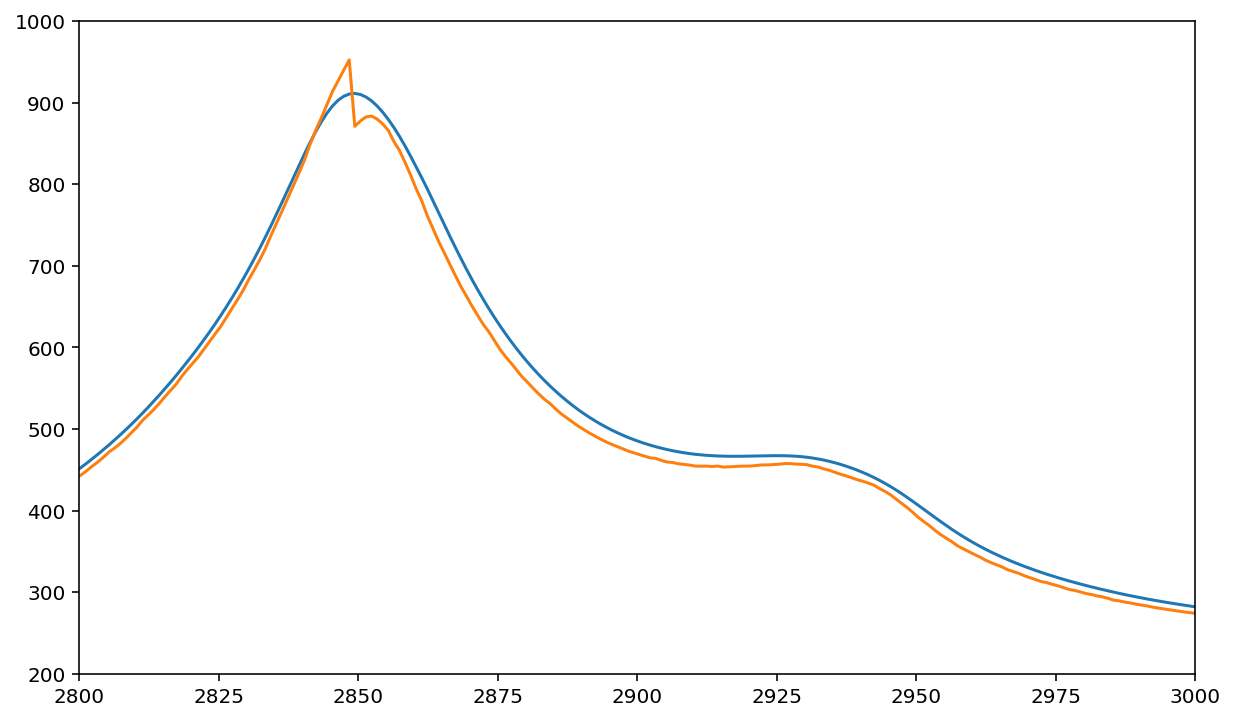

In [20]:
plt.figure(figsize=[10,6])
plt.plot(nwave+11,output[0])
plt.plot(nw,flux_comp*120)
plt.xlim(2800,3000)
plt.ylim(200,1000)

[2.00187034e+00 1.54867715e+03 1.24774434e+02 9.66722951e+01
 5.00000000e-02 1.36199873e+00]


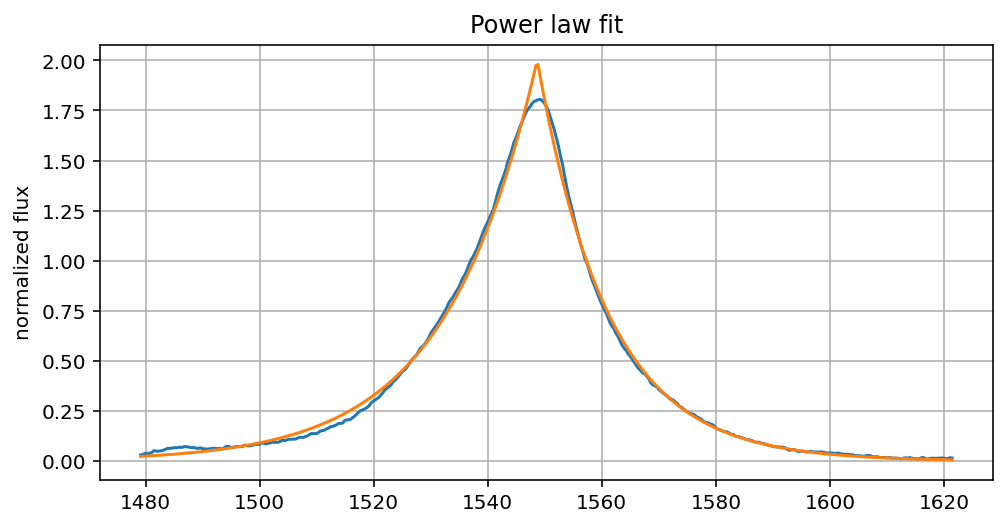

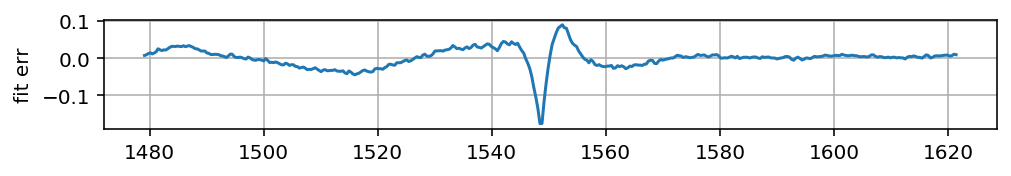

In [21]:
'''
This part is just fit the data, no M.L. happens yet...
'''
wave_data = wave_comp[3700:4100].astype(np.float32)
flux_data = flux_comp[3700:4100].astype(np.float32)
noisy_flux_data = noisify(flux_data,0.1)

input_wave_data = torch.tensor(wave_data.reshape(400,1),dtype=torch.float)
input_flux_data = torch.tensor(flux_data.reshape(400,1),dtype=torch.float)
input_noisy_flux_data = torch.tensor(noisy_flux_data.reshape(400,1),dtype=torch.float)

test_wave_data = torch.linspace(1480,1620,400).reshape(400,1)

from scipy.optimize import curve_fit
# Guess parameters
parameters, covariance = curve_fit(Jiamu_powerlaw, wave_data, flux_data, 
                                p0 = [1, 1549, 50, 50, 0.01, 2],
                                  bounds=([0.,0.,0.,0.,0.,0.], 
                                          [30, 1549, 300, 300, 10, 10]))
F0 = parameters[0]
x0 = parameters[1]
alpha = parameters[2]
beta = parameters[3]

C = parameters[4]
D = parameters[5]

print(parameters)

plt.figure(figsize=[8,4])
plt.plot(input_wave_data,input_flux_data - underline(test_wave_data,C,D))
plt.plot(wave_data, Jiamu_powerlaw(wave_data,F0,x0,alpha, beta, C, D) - underline(wave_data,C,D))
plt.grid()
plt.ylabel('normalized flux')
plt.title('Power law fit')
plt.figure(figsize=[8,1])
plt.plot(wave_data,flux_data -\
         Jiamu_powerlaw(wave_data,F0,x0,alpha, beta, C, D))
plt.ylabel('fit err')
plt.grid();

[1.43954512e-02 1.05931688e+00 1.54621330e+03 1.50000000e+01
 1.43954512e-02 7.01896649e-01 1.54868391e+03 4.82708161e+00
 6.08334854e-04 1.00000010e+00]


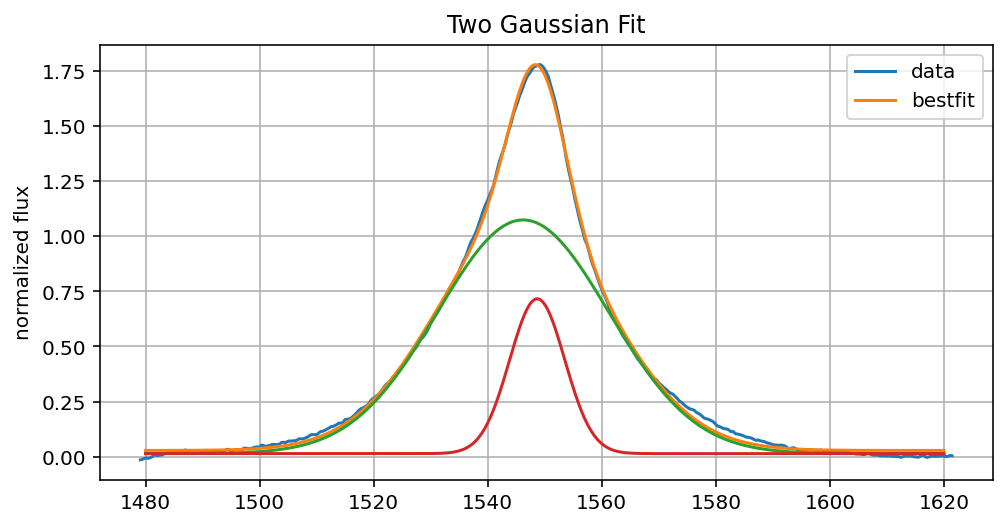

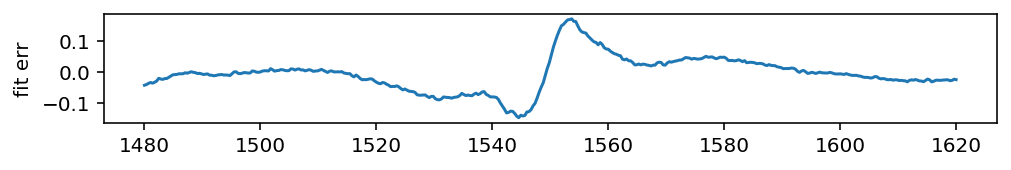

In [22]:
wave_data = wave_comp[3700:4100].astype(np.float32)
flux_data = flux_comp[3700:4100].astype(np.float32)
noisy_flux_data = noisify(flux_data,0.1)

input_wave_data = torch.tensor(wave_data.reshape(400,1),dtype=torch.float)
input_flux_data = torch.tensor(flux_data.reshape(400,1),dtype=torch.float)
input_noisy_flux_data = torch.tensor(noisy_flux_data.reshape(400,1),dtype=torch.float)

test_wave_data = torch.linspace(1480,1620,400).reshape(400,1)

from scipy.optimize import curve_fit
# Guess parameters
parameters, covariance = curve_fit(twogaussian, wave_data, flux_data, 
                                p0 = [0, 2, 1549, 10, 0, 2, 1549, 5, 0.01, 2],
                                  bounds=([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.], 
                                          [1.3, 2, 1549, 15, 1.3, 2, 1549, 15, 1, 15]))
H = parameters[0]
A = parameters[1]
x0 = parameters[2]
sigma = parameters[3]

H1 = parameters[4]
A1 = parameters[5]
x01 = parameters[6]
sigma1 = parameters[7]

C = parameters[8]
D = parameters[9]

print(parameters)

plt.figure(figsize=[8,4])
plt.plot(input_wave_data,input_flux_data - underline(test_wave_data,C,D), label='data')
plt.plot(test_wave_data,
         twogaussian(test_wave_data,H,A,x0,sigma, H1,A1,x01,sigma1, C,D)- underline(test_wave_data,C,D),
         label='bestfit')
plt.plot(test_wave_data,gaussian(test_wave_data,H,A,x0,sigma))
plt.plot(test_wave_data,gaussian(test_wave_data,H1,A1,x01,sigma1))
plt.grid()
plt.ylabel('normalized flux')
plt.title('Two Gaussian Fit')
plt.legend()
plt.figure(figsize=[8,1])
plt.plot(test_wave_data,input_flux_data -\
         twogaussian(test_wave_data,H,A,x0,sigma, H1,A1,x01,sigma1, C,D))
plt.ylabel('fit err');

In [23]:
nTrain = 100
wavSize = 400

two_d = np.vstack((wave_data,noisify(flux_data,0.2)))# combine flux and wavelength into one array with dim (2,400)
two_d_tensor = torch.tensor(two_d.T,dtype=torch.float)

best_fit = twogaussian(test_wave_data,H,A,x0,sigma, H1,A1,x01,sigma1,C,D)- underline(test_wave_data,C,D)
test_flux_data = best_fit
two_d_test = np.vstack((test_wave_data.T,test_flux_data.T))
two_d_tensor_test = torch.tensor(two_d_test.T,dtype=torch.float)

In [24]:
print(two_d_tensor.shape)
print(two_d_tensor_test.shape)

torch.Size([400, 2])
torch.Size([400, 2])


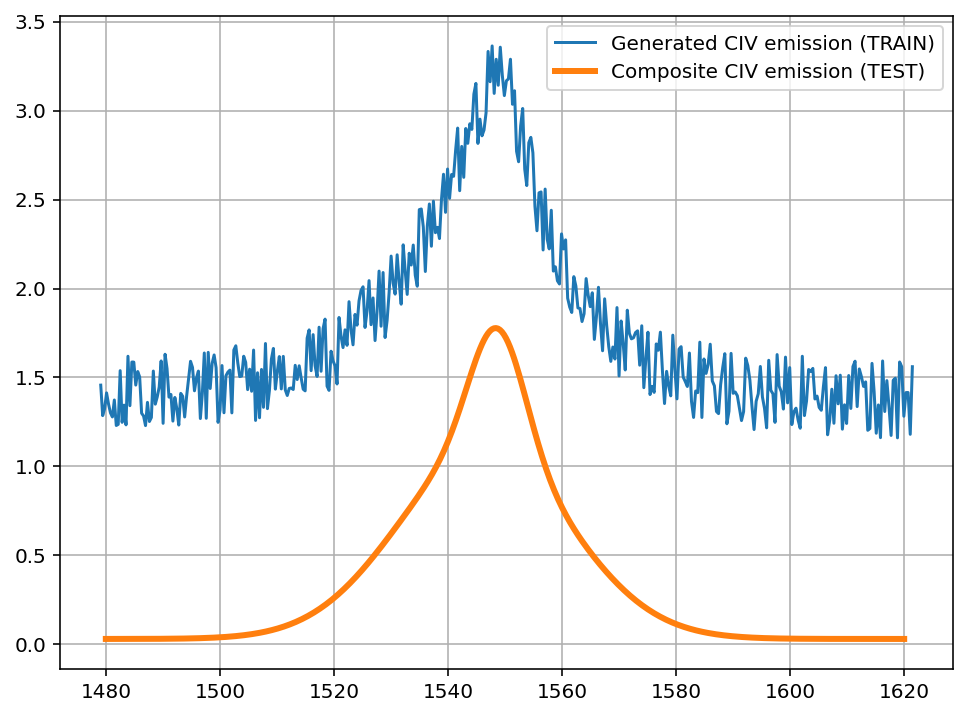

In [25]:
plt.figure(figsize=[8,6])
plt.plot(two_d[0],two_d[1], label='Generated CIV emission (TRAIN)')
plt.plot(two_d_test[0],two_d_test[1], lw=3, label='Composite CIV emission (TEST)')
plt.legend()
plt.grid(True)

In [26]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(2, 30),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(30, 15),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(15, 2),
)

In [27]:
torch.save(net.state_dict(), 'net2d.pth')

Completed epoch  0 in  0.0s, Train loss=1.0e+06
Completed epoch  1 in  0.0s, Train loss=9.2e+05
Completed epoch  2 in  0.0s, Train loss=8.0e+05
Completed epoch  3 in  0.0s, Train loss=6.8e+05
Completed epoch  4 in  0.0s, Train loss=5.5e+05
Completed epoch  5 in  0.0s, Train loss=4.3e+05
Completed epoch  6 in  0.0s, Train loss=3.1e+05
Completed epoch  7 in  0.0s, Train loss=2.0e+05
Completed epoch  8 in  0.0s, Train loss=1.1e+05
Completed epoch  9 in  0.0s, Train loss=4.6e+04
Completed epoch 10 in  0.0s, Train loss=7.6e+03
Completed epoch 11 in  0.0s, Train loss=2.0e+03
Completed epoch 12 in  0.0s, Train loss=2.5e+04
Completed epoch 13 in  0.0s, Train loss=6.5e+04
Completed epoch 14 in  0.0s, Train loss=1.0e+05
Completed epoch 15 in  0.0s, Train loss=1.2e+05
Completed epoch 16 in  0.0s, Train loss=1.1e+05
Completed epoch 17 in  0.0s, Train loss=9.5e+04
Completed epoch 18 in  0.0s, Train loss=6.8e+04
Completed epoch 19 in  0.0s, Train loss=4.1e+04
Completed epoch 20 in  0.0s, Train loss=

Completed epoch 272 in  0.0s, Train loss=4.2e-01
Completed epoch 273 in  0.0s, Train loss=4.2e-01
Completed epoch 274 in  0.0s, Train loss=4.2e-01
Completed epoch 275 in  0.0s, Train loss=4.2e-01
Completed epoch 276 in  0.0s, Train loss=4.2e-01
Completed epoch 277 in  0.0s, Train loss=4.2e-01
Completed epoch 278 in  0.0s, Train loss=4.2e-01
Completed epoch 279 in  0.0s, Train loss=4.2e-01
Completed epoch 280 in  0.0s, Train loss=4.2e-01
Completed epoch 281 in  0.0s, Train loss=4.2e-01
Completed epoch 282 in  0.0s, Train loss=4.2e-01
Completed epoch 283 in  0.0s, Train loss=4.2e-01
Completed epoch 284 in  0.0s, Train loss=4.2e-01
Completed epoch 285 in  0.0s, Train loss=4.2e-01
Completed epoch 286 in  0.0s, Train loss=4.2e-01
Completed epoch 287 in  0.0s, Train loss=4.2e-01
Completed epoch 288 in  0.0s, Train loss=4.2e-01
Completed epoch 289 in  0.0s, Train loss=4.2e-01
Completed epoch 290 in  0.0s, Train loss=4.2e-01
Completed epoch 291 in  0.0s, Train loss=4.2e-01
Completed epoch 292 

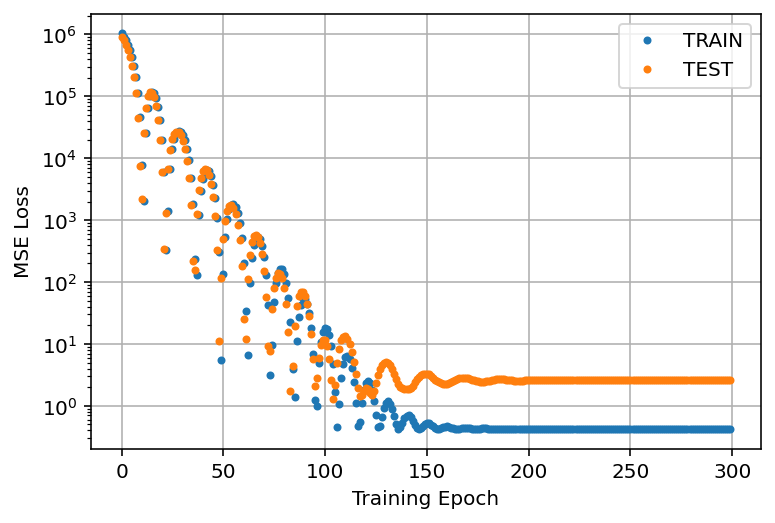

In [28]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
torch.manual_seed(123)
net.load_state_dict(torch.load('net2d.pth'))
losses_train, losses_test = [], []
for epoch in range(300):
    start_time = time.time()
    net.train()
    pred = net(two_d_tensor)
    loss = loss_fn(pred, two_d_tensor_test)
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    losses_train.append(loss.data)
    net.eval()
    pred = net(two_d_tensor_test)
    losses_test.append(loss_fn(pred, two_d_tensor).data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e" % (epoch, elapsed_time, loss.data))    
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.grid(True);

#### This does not work well...the MSE loss is too high!

#### To simplify the problem, I then tried to generate many (1000) gaussian functions to train the network. 

In [29]:
nGauss  = 1000
pixSize = 400 
civ_cent = 1546

'''
nGauss: the number of Line Profiles (Start with Gaussian) needed to train the Fully-connected network

pixSize: the number of wavelength values, I chose 400 because the composite CIV width has size 400.

'''

x = np.linspace(civ_cent-40,civ_cent+40,pixSize)

# initialize tensors
lines = torch.zeros(nGauss,pixSize)
labels = torch.zeros(nGauss,3)

for i in range(nGauss):

    # location and width parameters
    cen = civ_cent + 2*np.random.randn() - 1 # center coordinate
    wid = np.random.rand()*100 # width of Gaussian
    fwhm = 2.355 * wid
    intensity = np.random.rand()*5
    
    # generate gaussian line profiles with random centers
    G  = np.exp(-(x-cen)**2 / wid) * intensity
    G  = G + np.random.randn(pixSize)/10

    # add to the tensor
    lines[i,:] = torch.Tensor(G).view(1,pixSize)
    labels[i,:] = torch.Tensor([cen,wid,intensity])

In [30]:
cen

1545.1178796134182

In [31]:
lines.shape

torch.Size([1000, 400])

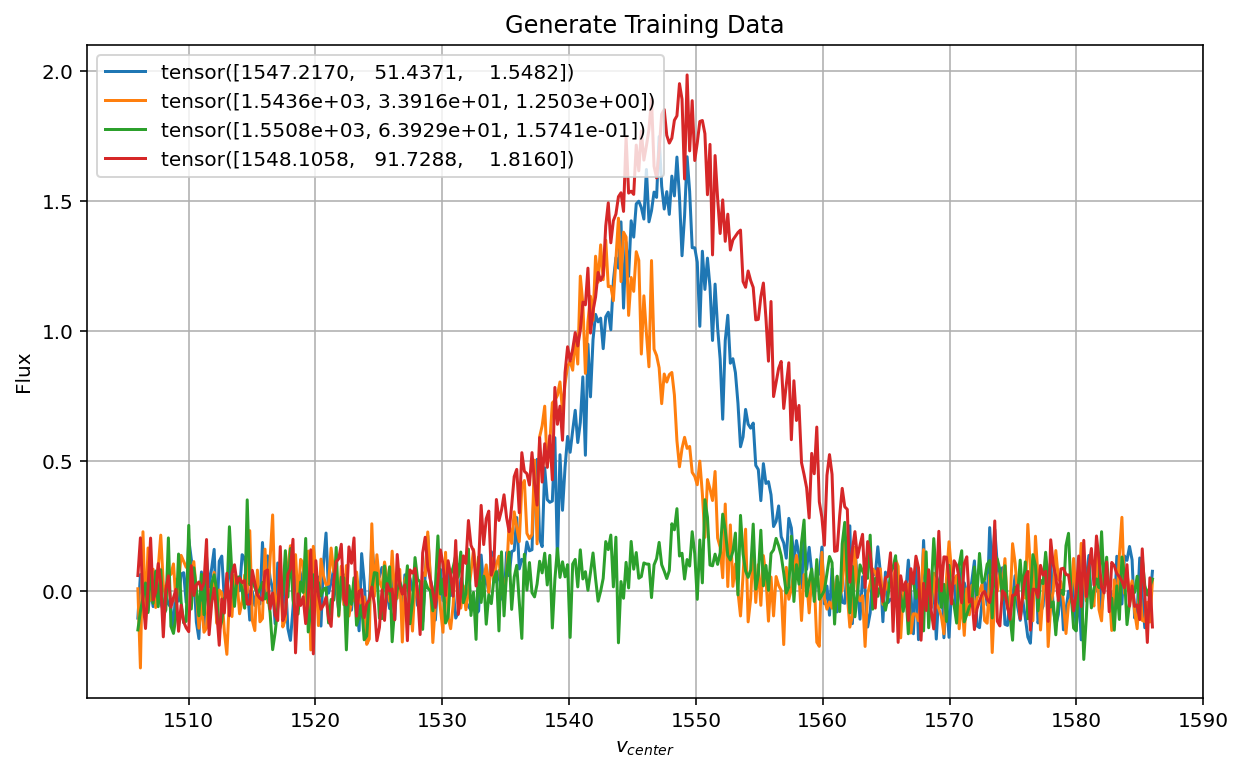

In [32]:
plt.figure(figsize=[10,6])
for i in range(4):
    plt.plot(x,lines[i], label=labels[i,:])
plt.legend()
plt.title('Generate Training Data')
plt.xlabel(r'$v_{center}$')
plt.ylabel('Flux')
plt.grid()

Note that the first element in the tensor is the center of the line $(v_{\rm center})$, the second element is the line width $(\rm FWHM)$, and the third element is the peak intensity $(I)$.

In [33]:
# turn 10 percent of the data (n = 100) to be the test data
train_data,test_data, train_labels,test_labels = train_test_split(lines, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into 2000/5 = 400 batches
batchsize    = 5
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [34]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([900, 400])
torch.Size([900, 3])


## Fully connected networks

In [35]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(400, 30),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(30, 15),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(15, 3),
)

The neural net takes 400 as the input dimension since that is the spectral range for CIV that we selected earlier, the hidden layer reduce the dimension to 15, and the output has dimension of 3 (intensity, FWHM, and central wavelength).

In [36]:
torch.save(net.state_dict(), 'net.pth')

In [37]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
torch.manual_seed(123)
net.load_state_dict(torch.load('net.pth'))
losses_train, losses_test = [], []
for epoch in range(800):
    start_time = time.time()
    net.train()
    for x_batch, y_batch in train_loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses_train.append(loss.data)
    net.eval()
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e" % (epoch, elapsed_time, loss.data))    

Completed epoch  0 in  0.1s, Train loss=3.2e+05
Completed epoch  1 in  0.1s, Train loss=4.7e+04
Completed epoch  2 in  0.1s, Train loss=3.8e+05
Completed epoch  3 in  0.1s, Train loss=9.3e+04
Completed epoch  4 in  0.1s, Train loss=1.5e+05
Completed epoch  5 in  0.1s, Train loss=5.4e+04
Completed epoch  6 in  0.1s, Train loss=1.3e+05
Completed epoch  7 in  0.1s, Train loss=7.5e+04
Completed epoch  8 in  0.1s, Train loss=1.3e+05
Completed epoch  9 in  0.1s, Train loss=2.7e+05
Completed epoch 10 in  0.1s, Train loss=5.7e+04
Completed epoch 11 in  0.1s, Train loss=1.2e+05
Completed epoch 12 in  0.1s, Train loss=2.9e+05
Completed epoch 13 in  0.1s, Train loss=1.8e+05
Completed epoch 14 in  0.1s, Train loss=1.6e+05
Completed epoch 15 in  0.1s, Train loss=2.3e+05
Completed epoch 16 in  0.1s, Train loss=1.3e+05
Completed epoch 17 in  0.1s, Train loss=2.4e+05
Completed epoch 18 in  0.1s, Train loss=2.9e+05
Completed epoch 19 in  0.1s, Train loss=5.9e+04
Completed epoch 20 in  0.1s, Train loss=

Completed epoch 171 in  0.1s, Train loss=1.6e+02
Completed epoch 172 in  0.1s, Train loss=1.0e+02
Completed epoch 173 in  0.1s, Train loss=4.4e+01
Completed epoch 174 in  0.1s, Train loss=1.5e+02
Completed epoch 175 in  0.1s, Train loss=1.7e+02
Completed epoch 176 in  0.1s, Train loss=7.2e+01
Completed epoch 177 in  0.1s, Train loss=4.3e+01
Completed epoch 178 in  0.1s, Train loss=1.5e+02
Completed epoch 179 in  0.1s, Train loss=5.9e+01
Completed epoch 180 in  0.1s, Train loss=2.1e+02
Completed epoch 181 in  0.1s, Train loss=2.7e+02
Completed epoch 182 in  0.1s, Train loss=8.1e+01
Completed epoch 183 in  0.1s, Train loss=5.0e+01
Completed epoch 184 in  0.1s, Train loss=1.3e+02
Completed epoch 185 in  0.1s, Train loss=6.1e+01
Completed epoch 186 in  0.1s, Train loss=1.1e+02
Completed epoch 187 in  0.1s, Train loss=1.1e+02
Completed epoch 188 in  0.1s, Train loss=1.7e+02
Completed epoch 189 in  0.1s, Train loss=8.4e+01
Completed epoch 190 in  0.1s, Train loss=1.1e+02
Completed epoch 191 

Completed epoch 339 in  0.1s, Train loss=4.3e+01
Completed epoch 340 in  0.1s, Train loss=5.4e+01
Completed epoch 341 in  0.1s, Train loss=7.5e+01
Completed epoch 342 in  0.1s, Train loss=1.1e+02
Completed epoch 343 in  0.1s, Train loss=4.2e+01
Completed epoch 344 in  0.1s, Train loss=3.6e+01
Completed epoch 345 in  0.1s, Train loss=6.1e+01
Completed epoch 346 in  0.1s, Train loss=5.3e+01
Completed epoch 347 in  0.1s, Train loss=5.3e+01
Completed epoch 348 in  0.1s, Train loss=8.5e+01
Completed epoch 349 in  0.1s, Train loss=2.8e+01
Completed epoch 350 in  0.1s, Train loss=5.1e+01
Completed epoch 351 in  0.1s, Train loss=3.4e+01
Completed epoch 352 in  0.1s, Train loss=2.8e+02
Completed epoch 353 in  0.1s, Train loss=1.6e+02
Completed epoch 354 in  0.1s, Train loss=4.9e+01
Completed epoch 355 in  0.1s, Train loss=6.7e+01
Completed epoch 356 in  0.1s, Train loss=1.4e+01
Completed epoch 357 in  0.1s, Train loss=9.2e+00
Completed epoch 358 in  0.1s, Train loss=6.6e+01
Completed epoch 359 

Completed epoch 507 in  0.1s, Train loss=2.3e+01
Completed epoch 508 in  0.1s, Train loss=2.6e+01
Completed epoch 509 in  0.1s, Train loss=7.8e+00
Completed epoch 510 in  0.1s, Train loss=2.1e+01
Completed epoch 511 in  0.1s, Train loss=9.0e+01
Completed epoch 512 in  0.1s, Train loss=3.0e+01
Completed epoch 513 in  0.1s, Train loss=4.8e+01
Completed epoch 514 in  0.1s, Train loss=2.1e+01
Completed epoch 515 in  0.1s, Train loss=4.1e+02
Completed epoch 516 in  0.1s, Train loss=5.3e+01
Completed epoch 517 in  0.1s, Train loss=5.1e+01
Completed epoch 518 in  0.1s, Train loss=3.0e+01
Completed epoch 519 in  0.1s, Train loss=3.2e+01
Completed epoch 520 in  0.1s, Train loss=7.6e+01
Completed epoch 521 in  0.1s, Train loss=4.3e+01
Completed epoch 522 in  0.1s, Train loss=3.4e+01
Completed epoch 523 in  0.1s, Train loss=1.4e+01
Completed epoch 524 in  0.1s, Train loss=4.4e+02
Completed epoch 525 in  0.1s, Train loss=4.9e+01
Completed epoch 526 in  0.1s, Train loss=8.6e+01
Completed epoch 527 

Completed epoch 676 in  0.1s, Train loss=3.8e+01
Completed epoch 677 in  0.1s, Train loss=2.2e+02
Completed epoch 678 in  0.1s, Train loss=3.8e+01
Completed epoch 679 in  0.1s, Train loss=9.0e+01
Completed epoch 680 in  0.1s, Train loss=1.0e+01
Completed epoch 681 in  0.1s, Train loss=1.2e+02
Completed epoch 682 in  0.1s, Train loss=3.0e+01
Completed epoch 683 in  0.1s, Train loss=2.7e+01
Completed epoch 684 in  0.1s, Train loss=1.9e+01
Completed epoch 685 in  0.1s, Train loss=2.5e+02
Completed epoch 686 in  0.1s, Train loss=2.6e+01
Completed epoch 687 in  0.1s, Train loss=2.7e+01
Completed epoch 688 in  0.1s, Train loss=3.5e+01
Completed epoch 689 in  0.1s, Train loss=1.5e+01
Completed epoch 690 in  0.1s, Train loss=6.8e+01
Completed epoch 691 in  0.1s, Train loss=1.9e+01
Completed epoch 692 in  0.1s, Train loss=1.0e+01
Completed epoch 693 in  0.1s, Train loss=3.6e+01
Completed epoch 694 in  0.1s, Train loss=1.2e+02
Completed epoch 695 in  0.1s, Train loss=1.3e+03
Completed epoch 696 

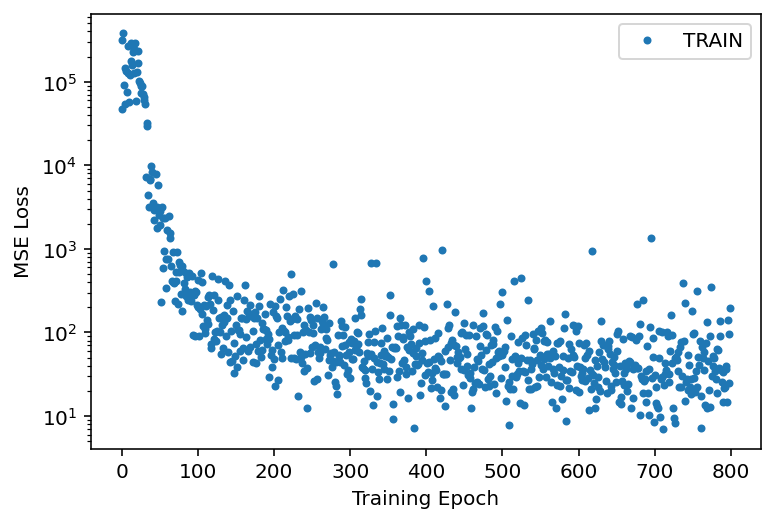

In [38]:
plt.plot(losses_train, '.', label='TRAIN')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

In [39]:
net.eval()
y = net(lines).detach().numpy()
truey = labels.detach().numpy()

In [40]:
lines

tensor([[-0.1034,  0.0644, -0.0317,  ..., -0.1255, -0.0424,  0.0768],
        [ 0.0095, -0.2950,  0.2288,  ..., -0.0424, -0.1183,  0.0404],
        [-0.1487, -0.0770, -0.0254,  ..., -0.0143,  0.0178,  0.0469],
        ...,
        [-0.0078, -0.0242,  0.1793,  ...,  0.0504,  0.0037,  0.2271],
        [-0.1126, -0.0288, -0.1395,  ...,  0.1217,  0.0175, -0.1337],
        [ 0.0406,  0.0345,  0.2346,  ..., -0.1219,  0.1274,  0.0121]])

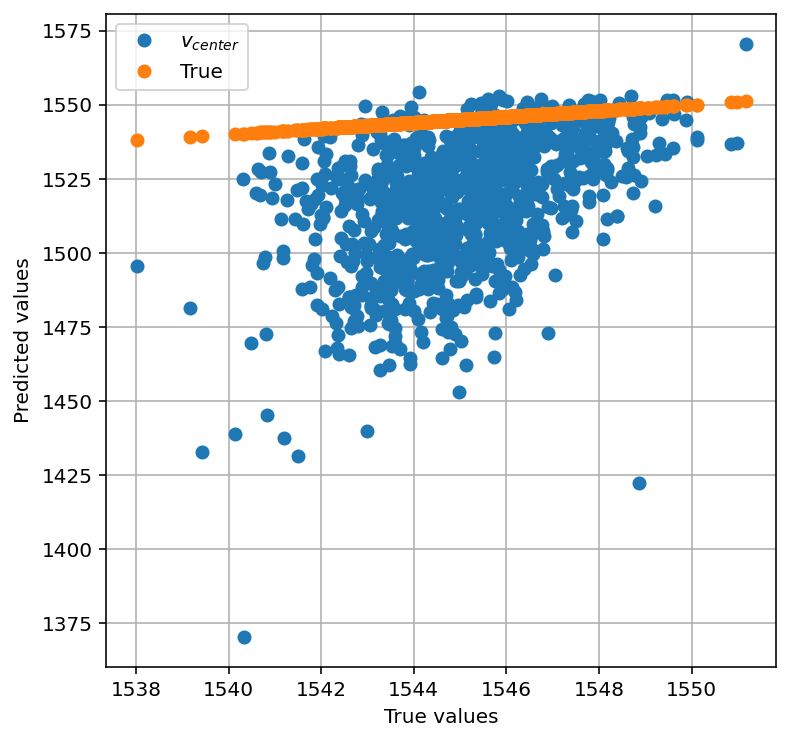

In [41]:
plt.figure(figsize=(6,6))
plt.plot(truey[:,0],y[:,0],'o',label=r'$v_{center}$')
plt.plot(truey[:,0],truey[:,0],'o',label=r'True')
plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

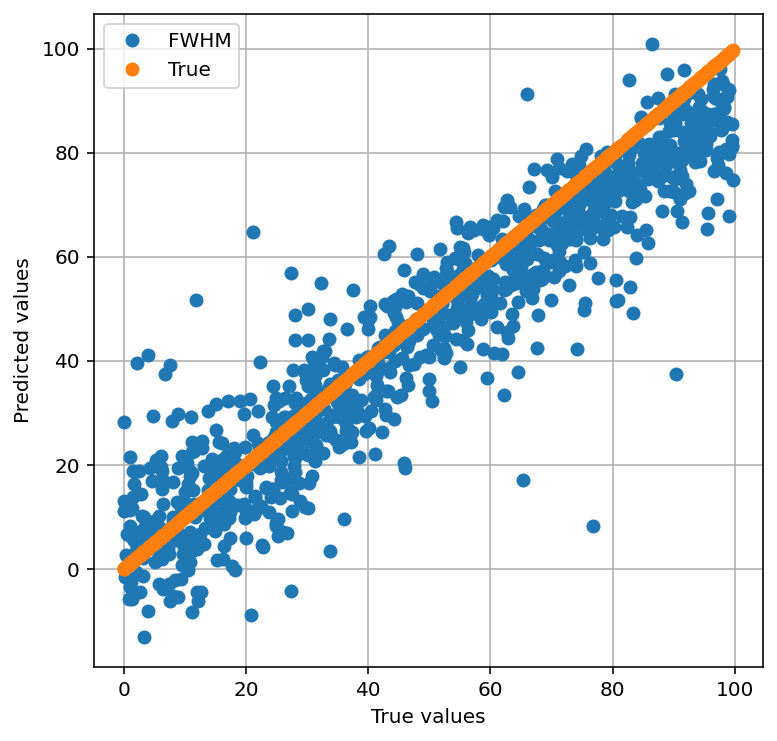

In [42]:
plt.figure(figsize=(6,6))
plt.plot(truey[:,1],y[:,1],'o',label='FWHM')
plt.plot(truey[:,1],truey[:,1],'o',label='True')
plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

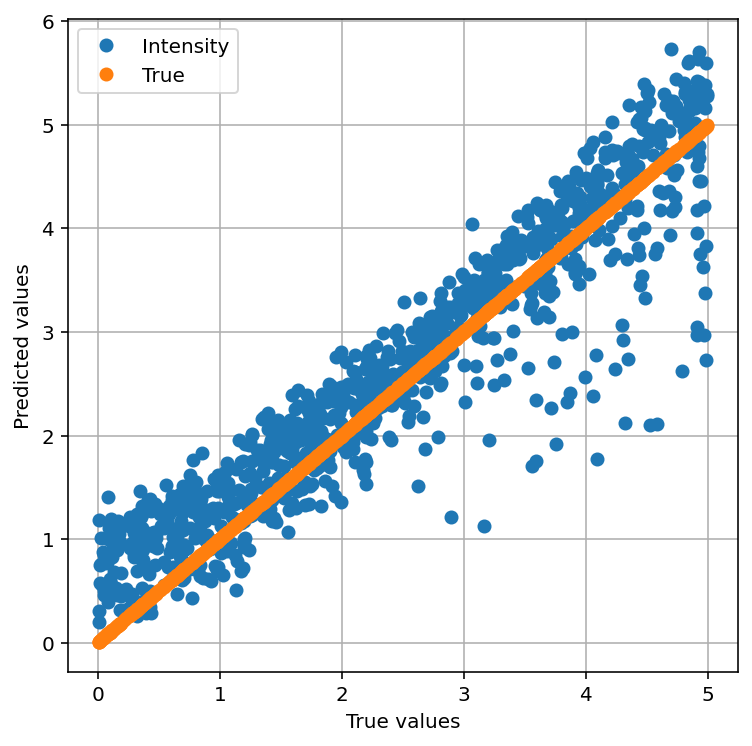

In [43]:
plt.figure(figsize=(6,6))
plt.plot(truey[:,2],y[:,2],'o',label='Intensity')
plt.plot(truey[:,2],truey[:,2],'o',label='True')
plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

Other than using MSE to visualize the error, it is better to plot the difference to see whether the predictions from the network is smaller or larger than the true value. So I am plotting (predicted values) - (true values).

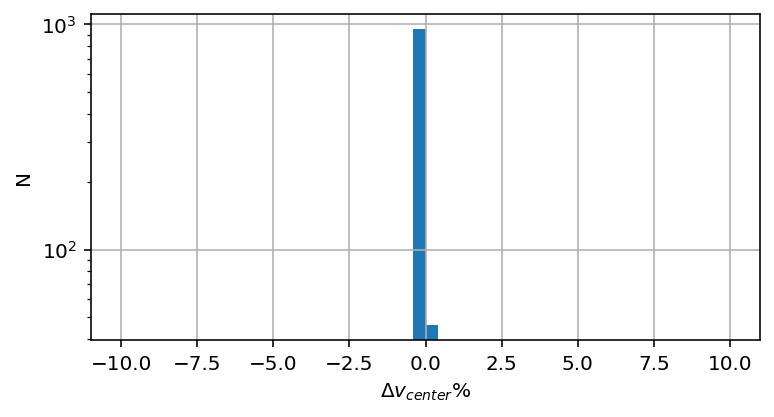

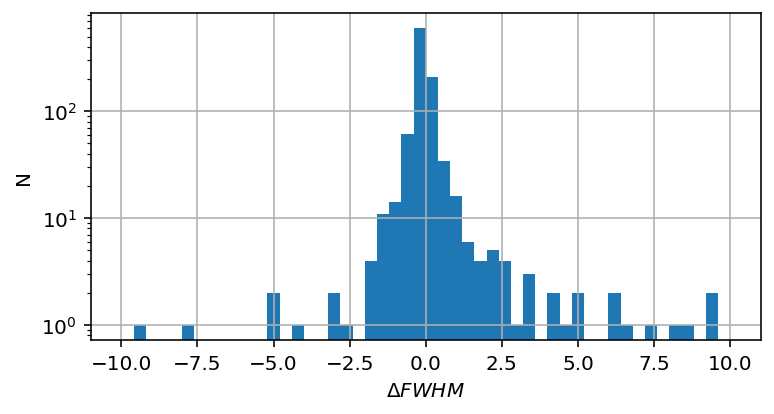

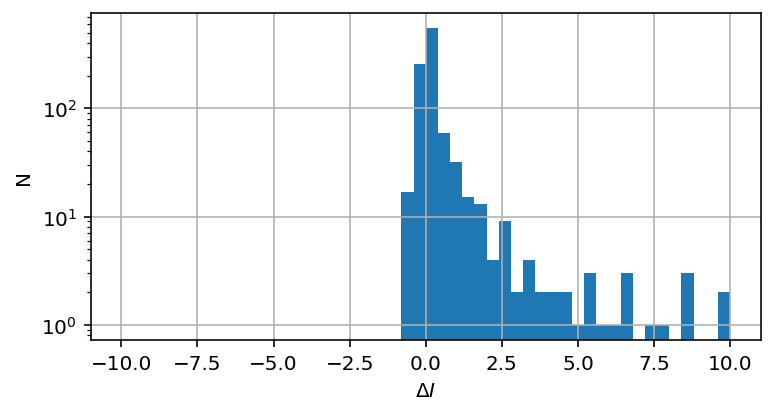

In [44]:
plt.figure(figsize=[6,3])
plt.hist((y[:,0]-truey[:,0])/truey[:,0], bins=50,range=(-10,10))
plt.yscale('log')
plt.xlabel(r'$\Delta v_{center}$%')
plt.ylabel('N')
plt.grid(True);

plt.figure(figsize=[6,3])
plt.hist((y[:,1]-truey[:,1])/truey[:,1], bins=50,range=(-10,10))
plt.yscale('log')
plt.xlabel(r'$\Delta FWHM$')
plt.ylabel('N')
plt.grid(True);

plt.figure(figsize=[6,3])
plt.hist((y[:,2]-truey[:,2])/truey[:,2], bins=50,range=(-10,10))
plt.yscale('log')
plt.xlabel(r'$\Delta I$')
plt.ylabel('N')
plt.grid(True);

In [45]:
net.eval()
y_try = net(two_d_tensor_test[:,1]).detach().numpy()

In [46]:
y_try

array([1.5159420e+03, 1.0506460e+02, 1.0200728e+00], dtype=float32)

In [47]:
wave_real = two_d_tensor_test[:,0].detach().numpy()
flux_real = two_d_tensor_test[:,1].detach().numpy()

In [48]:
guess = gaussian(wave_real, 0., y_try[2], y_try[0], y_try[1]/6)

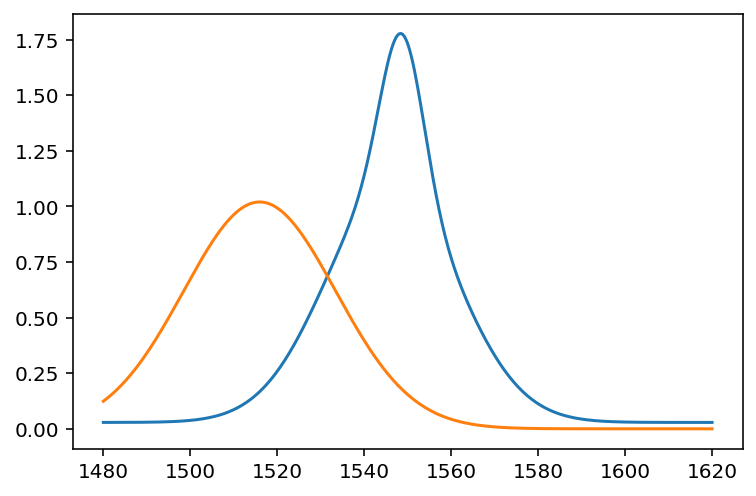

In [49]:
plt.plot(wave_real,flux_real, label='data')
plt.plot(wave_real,guess, label='data')

### What about using Autoencoders?

In [50]:
class AutoEncoder(nn.Module):
    def __init__(self, N, Nh = 50, Nlatent = 20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N, 2*N),
            nn.ReLU(),
            nn.Linear(2*N, Nh),
            nn.ReLU(),
            nn.Linear(Nh, Nlatent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(Nlatent, Nh),
            nn.ReLU(),
            nn.Linear(Nh, 2*N),
            nn.ReLU(),
            nn.Linear(2*N, 3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [51]:
Anet=AutoEncoder(400)
print(Anet)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=400, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=800, bias=True)
    (3): ReLU()
    (4): Linear(in_features=800, out_features=3, bias=True)
  )
)


Same as before, the input has dimension 400, then the encoder reduce the dimension to 20, which is the dimension of the latent space. Then the decoder gives an output of dimension 3.

In [52]:
train_data,test_data, train_labels,test_labels = train_test_split(lines, labels, test_size=.1)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 300
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [53]:
torch.manual_seed(123)
optimizer = torch.optim.Adam(Anet.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
losses_train, losses_test = [], []
for epoch in range(500):
    start_time = time.time()
    Anet.train()
    for x_batch, y_batch in train_loader:
        y_pred = Anet(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses_train.append(loss.data)
    Anet.eval()
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e" % (epoch, elapsed_time, loss.data))    

Completed epoch  0 in  0.1s, Train loss=7.4e+05
Completed epoch  1 in  0.1s, Train loss=1.6e+06
Completed epoch  2 in  0.1s, Train loss=4.7e+05
Completed epoch  3 in  0.1s, Train loss=6.2e+05
Completed epoch  4 in  0.1s, Train loss=5.1e+05
Completed epoch  5 in  0.1s, Train loss=3.9e+05
Completed epoch  6 in  0.1s, Train loss=2.4e+05
Completed epoch  7 in  0.1s, Train loss=2.4e+05
Completed epoch  8 in  0.1s, Train loss=2.6e+05
Completed epoch  9 in  0.1s, Train loss=2.1e+05
Completed epoch 10 in  0.1s, Train loss=2.0e+05
Completed epoch 11 in  0.1s, Train loss=1.7e+05
Completed epoch 12 in  0.1s, Train loss=1.7e+05
Completed epoch 13 in  0.1s, Train loss=1.8e+05
Completed epoch 14 in  0.1s, Train loss=1.7e+05
Completed epoch 15 in  0.1s, Train loss=1.6e+05
Completed epoch 16 in  0.1s, Train loss=1.5e+05
Completed epoch 17 in  0.1s, Train loss=1.4e+05
Completed epoch 18 in  0.1s, Train loss=1.2e+05
Completed epoch 19 in  0.1s, Train loss=1.0e+05
Completed epoch 20 in  0.1s, Train loss=

Completed epoch 171 in  0.1s, Train loss=7.6e+02
Completed epoch 172 in  0.1s, Train loss=4.6e+02
Completed epoch 173 in  0.1s, Train loss=1.0e+03
Completed epoch 174 in  0.1s, Train loss=3.6e+02
Completed epoch 175 in  0.1s, Train loss=7.9e+02
Completed epoch 176 in  0.1s, Train loss=3.8e+02
Completed epoch 177 in  0.1s, Train loss=5.3e+02
Completed epoch 178 in  0.1s, Train loss=3.1e+02
Completed epoch 179 in  0.1s, Train loss=3.3e+02
Completed epoch 180 in  0.1s, Train loss=2.8e+02
Completed epoch 181 in  0.1s, Train loss=3.4e+02
Completed epoch 182 in  0.1s, Train loss=3.0e+02
Completed epoch 183 in  0.1s, Train loss=3.6e+02
Completed epoch 184 in  0.1s, Train loss=9.1e+02
Completed epoch 185 in  0.1s, Train loss=5.5e+02
Completed epoch 186 in  0.1s, Train loss=6.5e+02
Completed epoch 187 in  0.1s, Train loss=3.2e+02
Completed epoch 188 in  0.1s, Train loss=7.3e+02
Completed epoch 189 in  0.1s, Train loss=7.9e+02
Completed epoch 190 in  0.1s, Train loss=4.3e+02
Completed epoch 191 

Completed epoch 339 in  0.1s, Train loss=2.0e+02
Completed epoch 340 in  0.1s, Train loss=2.9e+02
Completed epoch 341 in  0.1s, Train loss=4.8e+02
Completed epoch 342 in  0.1s, Train loss=9.5e+02
Completed epoch 343 in  0.1s, Train loss=2.6e+03
Completed epoch 344 in  0.1s, Train loss=3.3e+03
Completed epoch 345 in  0.1s, Train loss=1.6e+03
Completed epoch 346 in  0.1s, Train loss=1.3e+03
Completed epoch 347 in  0.1s, Train loss=3.0e+03
Completed epoch 348 in  0.1s, Train loss=2.3e+03
Completed epoch 349 in  0.1s, Train loss=1.3e+03
Completed epoch 350 in  0.1s, Train loss=2.8e+03
Completed epoch 351 in  0.1s, Train loss=1.6e+03
Completed epoch 352 in  0.1s, Train loss=9.1e+02
Completed epoch 353 in  0.1s, Train loss=2.4e+03
Completed epoch 354 in  0.1s, Train loss=4.8e+02
Completed epoch 355 in  0.1s, Train loss=2.1e+03
Completed epoch 356 in  0.1s, Train loss=5.1e+02
Completed epoch 357 in  0.1s, Train loss=9.7e+02
Completed epoch 358 in  0.1s, Train loss=3.0e+02
Completed epoch 359 

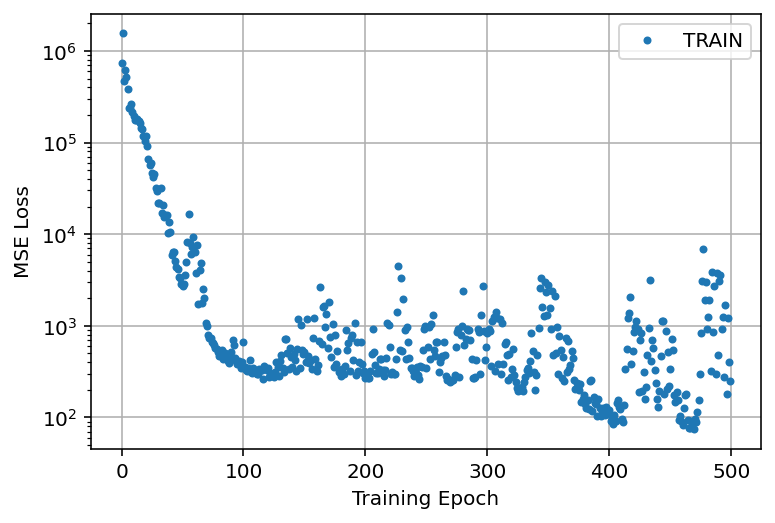

In [54]:
plt.plot(losses_train, '.', label='TRAIN')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.yscale('log');

In [55]:
Anet.eval()
y = Anet(lines).detach().numpy()
truey = labels.detach().numpy()

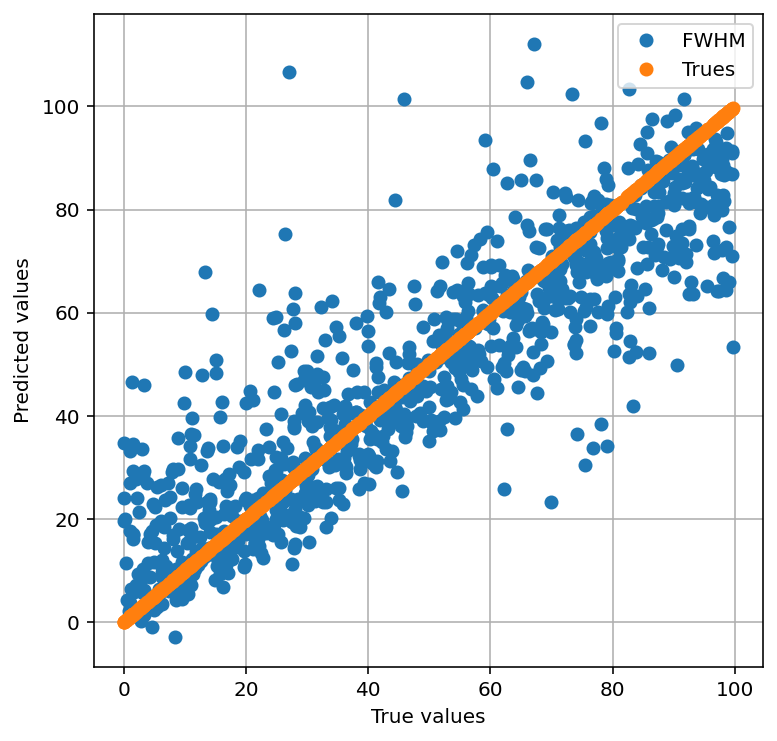

In [56]:
plt.figure(figsize=(6,6))
plt.plot(truey[:,1],y[:,1],'o',label='FWHM')
plt.plot(truey[:,1],truey[:,1],'o',label='Trues')
plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

Good. The AutoEncoder does a better job than the fully connected network in terms of the predicted values. However, its MSE loss oscillates and does not converge in the end. I tried different parameters for the batch size and learning rate, but $lr=0.01$ and $b=300$ seem to be the optimum, even though the MSE loss does not converge.

Compared with the fully connected network, the AutoEncoder also does a better job finding the FWHM of the lines (smaller standard deviation), but it is more biased toward giving larger FWHM than the true values. Also, the AutoEncoder predictions for intensities are also biased.

In [57]:
truey[:,0]

array([1547.217 , 1543.6165, 1550.8468, 1548.1058, 1542.8052, 1545.8508,
       1548.6371, 1548.1979, 1544.9329, 1543.8619, 1545.0051, 1544.19  ,
       1546.955 , 1543.9873, 1544.6954, 1545.4829, 1547.9478, 1546.9679,
       1547.6129, 1543.5573, 1544.4056, 1542.3185, 1545.792 , 1545.3976,
       1547.5884, 1545.5764, 1544.8033, 1545.8425, 1545.6614, 1545.9159,
       1543.6472, 1546.6993, 1542.0446, 1543.7031, 1543.4526, 1545.1732,
       1547.1332, 1544.2859, 1547.6508, 1544.1187, 1545.1447, 1544.9924,
       1543.4972, 1547.6011, 1546.1693, 1543.6812, 1546.8682, 1545.7075,
       1546.6862, 1543.9688, 1544.9884, 1546.0448, 1543.938 , 1547.6996,
       1545.3535, 1548.3816, 1544.4906, 1542.1984, 1544.9695, 1545.2079,
       1544.7277, 1547.3735, 1543.2172, 1542.0851, 1542.9667, 1542.7983,
       1545.4586, 1545.9067, 1545.6499, 1543.6027, 1544.6818, 1543.6163,
       1543.8813, 1544.8507, 1546.5947, 1542.4019, 1543.4037, 1543.1759,
       1546.0344, 1545.7253, 1543.8279, 1546.1711, 

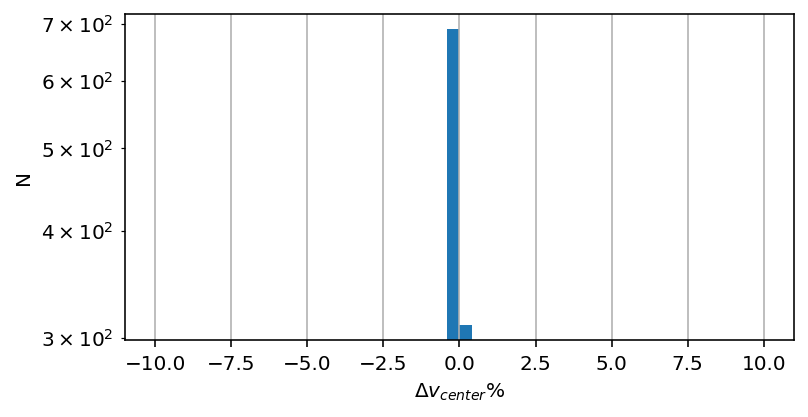

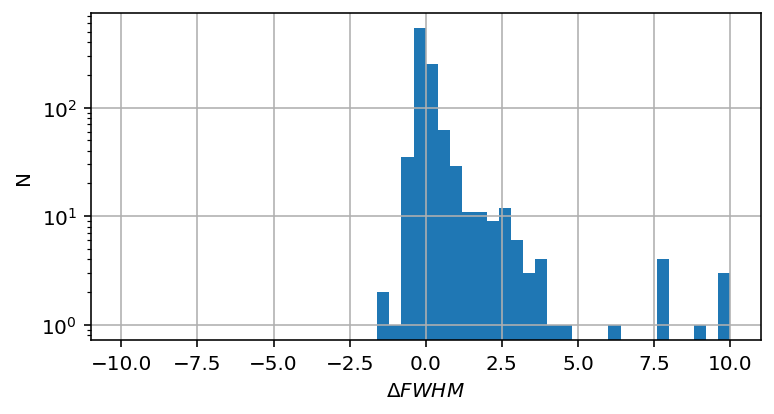

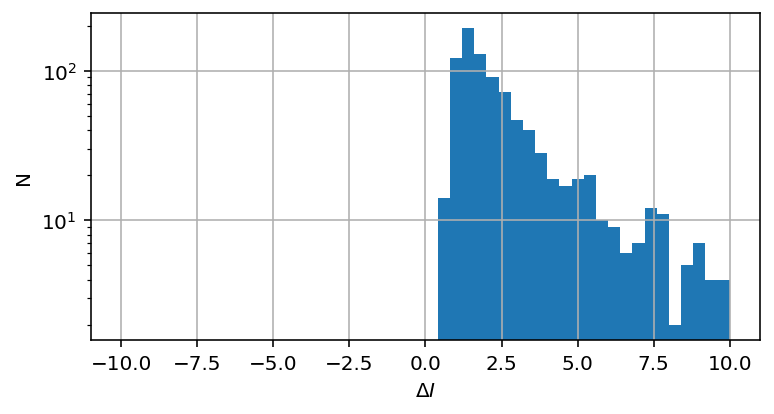

In [58]:
plt.figure(figsize=[6,3])
plt.hist((y[:,0]-truey[:,0])/truey[:,0], bins=50,range=(-10,10))
plt.yscale('log')
plt.xlabel(r'$\Delta v_{center}$%')
plt.ylabel('N')
plt.grid(True);

plt.figure(figsize=[6,3])
plt.hist((y[:,1]-truey[:,1])/truey[:,1], bins=50,range=(-10,10))
plt.yscale('log')
plt.xlabel(r'$\Delta FWHM$')
plt.ylabel('N')
plt.grid(True);

plt.figure(figsize=[6,3])
plt.hist((y[:,2]-truey[:,2])/truey[:,2], bins=50,range=(-10,10))
plt.yscale('log')
plt.xlabel(r'$\Delta I$')
plt.ylabel('N')
plt.grid(True);

CONCLUSIONS:

We trained both fully-connected networks and AutoEncoders to identify the three properties of the emission lines ($v_{\rm center}$, $\rm FWHM$, and $\rm I$). Both fully-connected networks and AutoEncoder give reasonable results that predict the emission line properties. However, there is a large spread in the difference between the true and predicted values. This could be due to the random errors between the train data, or it could be the central velocity of the training data gets very close to the edge of the selected range of wavelength, which makes it looks less like a Gaussian. 

In the future, I will try to generate more complicated functions (Two Gaussians + underline continuum,  Mulitple Lorentzian, and even the two-sided power-law that I created in the functions section) to train the neural network. In addition, I will expand the range of the training data to be the full spectrum, instead of only selecting the CIV region. I will also try to use the AutoEncoder to generate fake spectra for different input physical conditions, and that can be a separate project from this notebook.

In the end, I want to thank Professor Hance for teaching this amazing class! I had a lot of fun learning machine learning in my last quarter at UCSC.